# Нейронные сети: Autograd

## Библиотеки

In [ ]:
import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !wget -q -O requirements.txt https://raw.githubusercontent.com/andriygav/MachineLearningSeminars/master/sem2/requirements.txt
    !pip install -q -r requirements.txt

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import expit
import numpy as np
import torch

from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid


from torchvision import datasets
from torchvision import transforms

## Разбор домашней задачи

Рассмотрим совместное правдоподобие модели и данных:
$$
p\bigr(\mathbf{y}, \mathbf{w}|\mathbf{X}\bigr) = \prod_{i=1}^{l}p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr)p\bigr(\mathbf{w}\bigr),
$$
где для для простоты рассмотрим $p\bigr(\mathbf{w}\bigr)=\mathcal{N}\bigr(\mathbf{0}, \gamma\mathbf{I})$.

По принципу максимума правдоподобия получаем следующую функцию для минимизации:
$$
\mathcal{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr) = -\sum_{i=1}^{l}\log p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr) - \log p\bigr(\mathbf{w}\bigr) = \sum_{i=1}^{l}\left[\frac{\beta}{2}\left(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i-y_i\right)^2 + C_1\right] + \frac{\gamma}{2}\mathbf{w}^{\mathsf{T}}\mathbf{w} + C_2.
$$
Для удобства перепишем в матричном виде:
$$
\beta\sum_{i=1}^{l}\left(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i - y_i\right)^2 + \gamma\mathbf{w}^{\mathsf{T}}\mathbf{w}=
\beta\left(\mathbf{X}\mathbf{w} - \mathbf{y}\right)^{\mathsf{T}}\left(\mathbf{X}\mathbf{w} - \mathbf{y}\right)  + \gamma\mathbf{w}^{\mathsf{T}}\mathbf{w}= \\
=\beta\mathbf{w}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{w} - 2\beta\mathbf{y}\mathbf{X}\mathbf{w} + \beta\mathbf{y}^{\mathsf{T}}\mathbf{y} + \gamma\mathbf{w}^{\mathsf{T}}\mathbf{w}
$$


Воспользуемся необходимым условием первого порядка:
$$
\frac{\partial}{\partial \mathbf{w}}\left(\beta\mathbf{w}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{w} - 2\beta\mathbf{y}\mathbf{X}\mathbf{w} + \beta\mathbf{y}^{\mathsf{T}}\mathbf{y} + \gamma\mathbf{w}^{\mathsf{T}}\mathbf{w}\right) = 0 = 2\beta\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{w} - 2\beta\mathbf{X}^{\mathsf{T}}\mathbf{y} + 2\gamma\mathbf{w} \\
\Rightarrow \hat{\mathbf{w}} = \beta\left(\beta\mathbf{X}^{\mathsf{T}}\mathbf{X} + \gamma\mathbf{I}\right)^{-1}\mathbf{X}^{\mathsf{T}}\mathbf{y}
$$

In [ ]:
np.random.seed(0)
l = 1000
n = 2


X_train = np.random.randn(l, n)
X_test = np.random.randn(500, n)
w = np.random.randn(n)
Y_train = np.random.binomial(n=1, p=expit(X_train@w))
Y_test = np.random.binomial(n=1, p=expit(X_test@w))

In [ ]:
loo = KFold(10)
number_of_batch = loo.get_n_splits(X_train)

gamma_scores = dict()
gammas = [1e-10, 1e-4, 1e-3, 1e-2, .1, 1., 10., 1e2, 1e3, 1e4, 1e10]
for gamma in tqdm(gammas):
    list_of_scores = []
    for train_index, test_index in tqdm(loo.split(X_train), 
                                        total=number_of_batch, leave=False):
        x_train, x_test = X_train[train_index], X_train[test_index]
        y_train, y_test = Y_train[train_index], Y_train[test_index]

        model = LogisticRegression(penalty='l2', C=2/gamma, solver='saga',
                                   fit_intercept=False, random_state=0)
        model.fit(x_train, y_train)
        list_of_scores.append(model.score(x_test, y_test))
        
    gamma_scores[gamma] = np.mean(list_of_scores)

In [ ]:
best_gamma = sorted(gamma_scores, 
                    key=lambda x: gamma_scores[x], reverse=True)[0]

model = LogisticRegression(penalty='l2', C=2/best_gamma, fit_intercept=False, 
                           random_state=0, solver='saga')
model.fit(X_train, Y_train)
print('Точность: {}'.format(model.score(X_test, Y_test)))

Точность: 0.766


In [ ]:
def get_line(a, b, c=0, x_min=-10, x_max=10):
    x1, y1 = -(-b+ c)/a, -1
    x2, y2 = -(b + c)/a, 1
    
    polynomial = np.poly1d(np.polyfit([x1, x2], [y1, y2], 1))
    x_axis = np.linspace(x_min, x_max)
    y_axis = polynomial(x_axis)
    
    return x_axis, y_axis

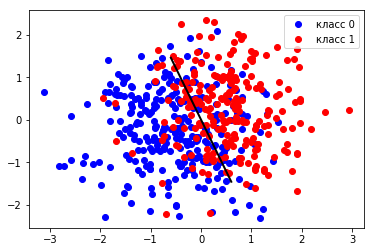

In [ ]:
cols = ['blue', 'red']

for k in np.unique(Y_test):
    plt.plot(X_test[Y_test==k,0], X_test[Y_test==k,1], 'o', 
             label='класс {}'.format(k), color=cols[k])

plt.plot(*get_line(*model.coef_[0], x_min=-0.6, x_max=0.6), 
         linewidth=2, color='black')

plt.legend(loc='best')
plt.show()

## Автоматическое дифференцирование

### Разбор примера
$$
f\bigr(\mathbf{x}\bigr) = x_3\cdot\cos\bigr(\frac{x_1}{x_2}\bigr)\cdot\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right)
$$

#### Граф вычислений
$$
f\bigr(\mathbf{x}\bigr) = x_3\cdot\cos\bigr(\frac{x_1}{x_2}\bigr)\cdot\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right)
$$
![](https://github.com/andriygav/MachineLearningSeminars/blob/master/sem3/fig1.png?raw=1)

$$
f\bigr(\mathbf{x}\bigr) = x_3\cdot\cos\bigr(\frac{x_1}{x_2}\bigr)\cdot\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right)
$$

#### Дифференцирование вперед
- $\frac{\partial z_1}{\partial x_1} = \frac{1}{x_2}$
- $\frac{\partial z_2}{\partial x_1} = 0$
- $\frac{\partial z_3}{\partial x_1} = \frac{\partial z_3}{\partial z_1}\frac{\partial z_1}{\partial x_1} = -\sin\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}$
- $\frac{\partial z_4}{\partial x_1} = \frac{\partial z_4}{\partial z_1}\frac{\partial z_1}{\partial x_1} + \frac{\partial z_4}{\partial z_2}\frac{\partial z_2}{\partial x_1} = \frac{1}{x_2}$
- $\frac{\partial z_5}{\partial x_1} = \frac{\partial z_5}{\partial z_3}\frac{\partial z_3}{\partial x_1} + \frac{\partial z_5}{\partial z_4}\frac{\partial z_4}{\partial x_1} = -\sin\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right) +\cos\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}$
- $\frac{\partial z_6}{\partial x_1} = \frac{\partial z_6}{\partial z_5}\frac{\partial z_5}{\partial x_1} + \frac{\partial z_6}{\partial x_3}\frac{\partial x_3}{\partial x_1} = x_3\left(-\sin\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right) +\cos\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}\right)$
- $\frac{\partial f}{x_1}= \frac{\partial f}{\partial x_1}\frac{\partial z_6}{\partial x_1} = x_3\left(-\sin\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right) +\cos\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}\right)$

$$
f\bigr(\mathbf{x}\bigr) = x_3\cdot\cos\bigr(\frac{x_1}{x_2}\bigr)\cdot\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right)
$$

#### Дифференцирование назад
- $\frac{\partial f}{\partial z_6} = 1$
- $\frac{\partial f}{\partial z_5} = \frac{\partial f}{\partial z_6}\frac{\partial z_6}{\partial z_5} = x_3$
- $\frac{\partial f}{\partial z_4} = \frac{\partial f}{\partial z_5}\frac{\partial z_5}{\partial z_4} = x_3\cos\bigr(\frac{x_1}{x_2}\bigr)$
- $\frac{\partial f}{\partial z_3} = \frac{\partial f}{\partial z_5}\frac{\partial z_5}{\partial z_3} = x_3\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right)$
- $\frac{\partial f}{\partial z_2} = \frac{\partial f}{\partial z_4}\frac{\partial z_4}{\partial z_2} = x_3\cos\bigr(\frac{x_1}{x_2}\bigr)$
- $\frac{\partial f}{\partial z_1} = \frac{\partial f}{\partial z_3}\frac{\partial z_3}{\partial z_1} + \frac{\partial f}{\partial z_4}\frac{\partial z_4}{\partial z_1} = -\sin\bigr(\frac{x_1}{x_2}\bigr)x_3\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right) -\sin\bigr(\frac{x_1}{x_2}\bigr)x_3\cos\bigr(\frac{x_1}{x_2}\bigr)$
- $\frac{\partial f}{\partial x_1} = \frac{\partial f}{\partial z_1}\frac{\partial z_1}{\partial x_1} = -\frac{1}{x_2}\sin\bigr(\frac{x_1}{x_2}\bigr)x_3\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right) -\frac{1}{x_2}\sin\bigr(\frac{x_1}{x_2}\bigr)x_3\cos\bigr(\frac{x_1}{x_2}\bigr)$


### Плюсы и минусы каждого метода
Дифференцирование вперед:
- использует меньше памяти чем дифференцирование назад;
- вычислительная сложность зависит от числа параметров.

Дифференцирование назад:
- использует больше памяти чем дифференцирование вперед;
- вычислительная сложность не зависит от числа параметров.

## MNIST Dataset

In [ ]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=transforms.ToTensor())

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=transforms.ToTensor())

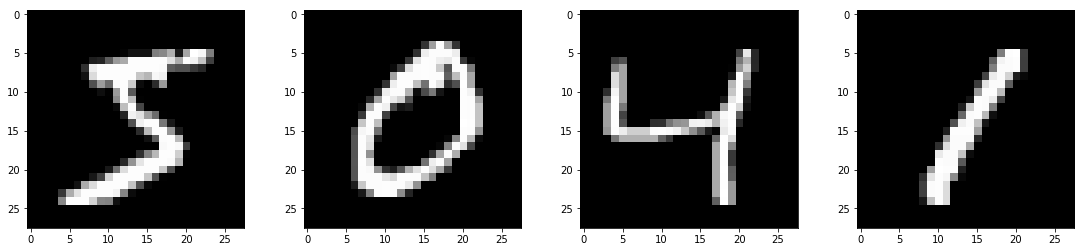

In [ ]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []

for i in range(4):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(MNIST_train[i][0][0]), 'gray')

plt.show()

### Полносвязная нейронная сеть (Персептрон)
![](https://github.com/andriygav/MachineLearningSeminars/blob/master/sem3/fig2.png?raw=1)

Перепишем в матричном виде:
$$
f(\mathbf{x}, \mathbf{W}) = \mathbf{W}_{n_2+1}\sigma\bigr( \cdots\mathbf{W}_2\sigma\bigr(\mathbf{W}_{1}\mathbf{x}\bigr)\cdots\bigr)
$$

В данном примере введены следующие обозначения:
- число $n$ --- размерность пространства признаков (`input_dim`);
- число $n_1$ --- размерность скрытого слоя (`hidden_dim`);
- число $n_2$ --- количество скрытых слоев (`num_layers`);
- число $n_3$ --- размерность пространства ответов (`output_dim`).

Заметим, что при $n_2=0$ получаем линейную модель, то есть линейная модель это частный случай полносвязного персептрона.

P.S. размерность скрытого слоя может зависить от номера слоя, для простоты рассмотрим фиксируемый размер скрытого слоя.

In [ ]:
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, input_dim=784, num_layers=0, 
                 hidden_dim=64, output_dim=10, p=0.0):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), 
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
        
        self.layers.add_module('classifier', 
                               torch.nn.Linear(prev_size, output_dim))        
        
    def forward(self, input):
        return self.layers(input)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = Perceptron()
model.to(device)

Perceptron(
  (layers): Sequential(
    (classifier): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [ ]:
model = Perceptron(num_layers=1)
model.to(device)

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=784, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
model = Perceptron(num_layers=2)
model.to(device)

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=784, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (layer1): Linear(in_features=64, out_features=64, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
def testing(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)

    pred = []
    real = []
    for x, y in generator:
        x = x.view([-1, 784]).to(device)
        y = y.to(device)

        pred.extend(torch.argmax(model(x), dim=-1).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())

    return np.mean(np.array(real) == np.array(pred)), \
           classification_report(real, pred)

In [ ]:
def trainer(model, dataset, loss_function, optimizer, epochs):
    for epoch in tqdm(range(epochs), leave=False):
        generator = torch.utils.data.DataLoader(dataset, batch_size=64, 
                                              shuffle=True)
        for x, y in tqdm(generator, leave=False):
            optimizer.zero_grad()
            x = x.view([-1, 784]).to(device)
            y = y.to(device)

            output = model(x)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

In [ ]:
def draw_table(data, title=['ACCURACY'], width=[60, 11]):    
    row_format = '|' + '|'.join([("{:>"+str(w)+"}") for w in width]) + '|'
    row_format_bet = '+' + '+'.join([("{:>"+str(w)+"}") for w in width]) + '+'
    
    print(row_format_bet.format(
        "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    print(row_format.format("", *title))
    print(row_format_bet.format(
        "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    for key in data:
        if len(key) > width[0]:
            row_name = '...' + key[len(key)-width[0]+3:]
        else:
            row_name = key
        print(row_format.format(row_name, *[round(x, 2) for x in data[key]]))
        print(row_format_bet.format(
            "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))

In [ ]:
model = Perceptron(num_layers=0)
model.to(device)

In [ ]:
_ = model.eval()
acc, report = testing(model, MNIST_test)
print(report)

              precision    recall  f1-score   support

           0       0.04      0.00      0.00       980
           1       0.01      0.03      0.02      1135
           2       0.19      0.07      0.10      1032
           3       0.03      0.01      0.01      1010
           4       0.10      0.22      0.13       982
           5       0.05      0.04      0.05       892
           6       0.11      0.00      0.00       958
           7       0.10      0.24      0.14      1028
           8       0.10      0.05      0.07       974
           9       0.11      0.11      0.11      1009

    accuracy                           0.08     10000
   macro avg       0.08      0.08      0.06     10000
weighted avg       0.08      0.08      0.06     10000



In [ ]:
_ = model.train()
trainer(model=model, 
        dataset=MNIST_train, 
        loss_function=torch.nn.CrossEntropyLoss(), 
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001), 
        epochs=4)

In [ ]:
_ = model.eval()
acc, report = testing(model, MNIST_test)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.94      0.89      0.91      1032
           3       0.90      0.92      0.91      1010
           4       0.91      0.95      0.93       982
           5       0.92      0.85      0.89       892
           6       0.94      0.96      0.95       958
           7       0.92      0.93      0.92      1028
           8       0.86      0.90      0.88       974
           9       0.92      0.89      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.92     10000



#### Гиперпараметры, которые нужно подобрать
- num_layers
- hidden_dim
- lr
- p

Воспользуемся Cross Validation для их подбора.

In [ ]:
cross_val = KFold(3)
number_of_batch = cross_val.get_n_splits(MNIST_train)

grid = ParameterGrid({'num_layers': [0, 2], 
                      'hidden_dim': [8, 64],
                      'p': [0.3, 0.7],
                      'lr': [0.001]})

X_train = MNIST_train.transform(MNIST_train.data.numpy()).transpose(0,1)
Y_train = MNIST_train.targets.data

In [ ]:
scores = dict()
for item in tqdm(grid):
    list_of_scores = []
    for train_index, test_index in tqdm(cross_val.split(X_train), 
                                        total=number_of_batch, leave=False):
        x_train_fold = X_train[train_index]
        x_test_fold = X_train[test_index]
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]

        traindata = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
        testdata = torch.utils.data.TensorDataset(x_test_fold, y_test_fold)

        model = Perceptron(num_layers=item['num_layers'], p=item['p'],
                           hidden_dim=item['hidden_dim'])
        model.to(device)
        _ = model.train()
        trainer(model=model, 
                dataset=traindata, 
                loss_function=torch.nn.CrossEntropyLoss(), 
                optimizer=torch.optim.Adam(model.parameters(), lr=item['lr']), 
                epochs=4)
        
        _ = model.eval()
        acc, report = testing(model, testdata)
        list_of_scores.append(acc)
    scores[str(item)] = [np.mean(list_of_scores)]

In [ ]:
draw_table(scores)

+------------------------------------------------------------+------------+
|                                                            |    ACCURACY|
+------------------------------------------------------------+------------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 0, 'p': 0.3}|        0.92|
+------------------------------------------------------------+------------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 0, 'p': 0.7}|        0.92|
+------------------------------------------------------------+------------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 2, 'p': 0.3}|         0.8|
+------------------------------------------------------------+------------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 2, 'p': 0.7}|        0.59|
+------------------------------------------------------------+------------+
|  {'hidden_dim': 64, 'lr': 0.001, 'num_layers': 0, 'p': 0.3}|        0.92|
+------------------------------------------------------------+------------+
|  {'hidden_

## Прореживание нейросетей

<img src="https://github.com/andriygav/MachineLearningSeminars/blob/master/sem3/fig3.png?raw=1" alt="drawing" width="400"/>

1 - Произвольное удаление параметров 2 - Optimal Brain Damage
3 - Variational Method               4 - Удаление зависимых признаков

* *Грабовой А.В., Бахтеев О.Ю., Стрижов В.В.* Определение релевантности параметровнейросети // Информатика и ее применения, 2019.
* *Грабовой А.В., Бахтеев О. Ю., Стрижов В.В.* Введение отношения порядка на множествепараметров аппроксимирующих моделей // Информатика и ее применения, 2020.

<img src="https://github.com/andriygav/MachineLearningSeminars/blob/master/sem3/fig4.png?raw=1" alt="drawing" width="400"/>

1 - Произвольное удаление параметров 2 - Optimal Brain Damage
3 - Variational Method               4 - Удаление зависимых признаков

# Homework 3
## Task 1
Проделать то, что было на семинаре для выборки FashionMnist: подбор гиперпараметров модели (выполнить более подробно чем на семинаре), также провести анализ полученных результатов.


In [ ]:
FMNIST_train = datasets.FashionMNIST("./fminst_train",
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

FMIST_test = datasets.FashionMNIST("./fminst_test", 
                                   train=False,
                                   transform=transforms.ToTensor(),
                                   download=True)

In [ ]:
# Определим размер выборок
FMNIST_train.data.shape, FMIST_test.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

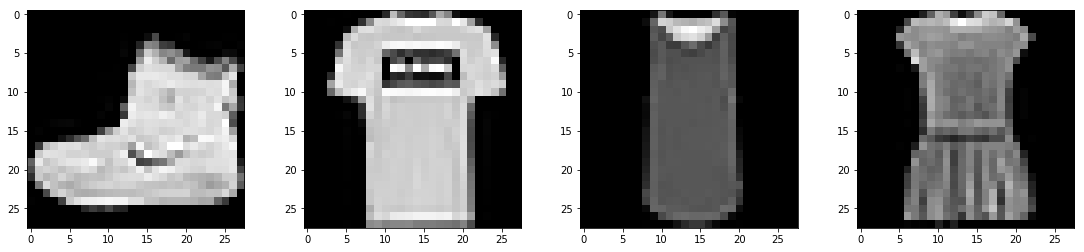

In [ ]:
# Рассмотрим несколько объектов из выборки:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []

for i in range(4):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(FMNIST_train[i][0][0]), 'gray')

plt.show()

In [ ]:
# Теперь определимся с количеством классов в выборке:

print(f"Total number of classes = {len(FMNIST_train.classes)}")
print(FMNIST_train.classes)

Total number of classes = 10
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Теперь, когда мы имеем некоторое представление о нашем даатасете, можно попробовать обучить т.н. "бейзлайн" - модель, качество которой мы будем пытаться в дальнейшем превзойти.

In [ ]:
baseline = Perceptron(input_dim=784, # количество классов остается прежним
                      num_layers=3, # соотвествующая теорема гласит, что такого числа классов достаточно.
                      hidden_dim=42, # см. "Автостопом по Галактике"
                      output_dim=10, # кол-во классов также остается прежним
                      p=0.0) # для бейзлайна нет необходимости думать о регуляризации
baseline.to(device=device)

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=784, out_features=42, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (layer1): Linear(in_features=42, out_features=42, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (layer2): Linear(in_features=42, out_features=42, bias=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=42, out_features=10, bias=True)
  )
)

In [ ]:
# Не забываем переводить модель в режим обучения.
# Хотя сейчас это фактически не играет никакой роли.

baseline.train()
trainer(model=baseline,
        dataset=FMNIST_train,
        loss_function=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(baseline.parameters(), lr=1e-3),
        epochs=10)

In [ ]:
baseline.eval()

acc, report = testing(baseline, FMIST_test)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1000
           1       0.99      0.96      0.97      1000
           2       0.85      0.68      0.76      1000
           3       0.86      0.90      0.88      1000
           4       0.75      0.84      0.79      1000
           5       0.95      0.95      0.95      1000
           6       0.67      0.72      0.69      1000
           7       0.96      0.90      0.93      1000
           8       0.97      0.97      0.97      1000
           9       0.91      0.97      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



Итак, наша отправная точка - ACCURACY = 0.87. Посмотрим, насколько подбор гиперпараметров сможет помочь улучшить этот показатель.

In [ ]:
cross_val = KFold(5) # классическое значение для kfold
number_of_batch = cross_val.get_n_splits(FMNIST_train)

param_grid = ParameterGrid(
    {'num_layers': [4, 5], 
    'hidden_dim': [42, 84],
    'p': [0.2, 0.4],
    'lr': [0.001]}
)

X_train = FMNIST_train.transform(FMNIST_train.data.numpy()).transpose(0, 1)
Y_train = FMNIST_train.targets.data

In [ ]:
# Заметим, что дальше ничего переписывать не нужно - мы все переопределили.
# А то значит, что настало время для copy&paste.

scores = dict()
for item in tqdm(param_grid):
    list_of_scores = []
    for train_index, test_index in tqdm(cross_val.split(X_train), 
                                        total=number_of_batch, leave=False):
        x_train_fold = X_train[train_index]
        x_test_fold = X_train[test_index]
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]

        traindata = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
        testdata = torch.utils.data.TensorDataset(x_test_fold, y_test_fold)

        model = Perceptron(num_layers=item['num_layers'], p=item['p'],
                           hidden_dim=item['hidden_dim'])
        model.to(device)
        _ = model.train()
        trainer(model=model, 
                dataset=traindata, 
                loss_function=torch.nn.CrossEntropyLoss(), 
                optimizer=torch.optim.Adam(model.parameters(), lr=item['lr']), 
                epochs=15)
        
        _ = model.eval()
        acc, report = testing(model, testdata)
        list_of_scores.append(acc)
    scores[str(item)] = [np.mean(list_of_scores)]

In [ ]:
draw_table(scores)

+------------------------------------------------------------+-----------+
|                                                            |   ACCURACY|
+------------------------------------------------------------+-----------+
|  {'hidden_dim': 42, 'lr': 0.001, 'num_layers': 4, 'p': 0.2}|       0.87|
+------------------------------------------------------------+-----------+
|  {'hidden_dim': 42, 'lr': 0.001, 'num_layers': 4, 'p': 0.4}|       0.79|
+------------------------------------------------------------+-----------+
|  {'hidden_dim': 42, 'lr': 0.001, 'num_layers': 5, 'p': 0.2}|       0.86|
+------------------------------------------------------------+-----------+
|  {'hidden_dim': 42, 'lr': 0.001, 'num_layers': 5, 'p': 0.4}|       0.74|
+------------------------------------------------------------+-----------+
|  {'hidden_dim': 84, 'lr': 0.001, 'num_layers': 4, 'p': 0.2}|       0.88|
+------------------------------------------------------------+-----------+
|  {'hidden_dim': 84, 'lr

### Выводы:

1. Видно, что dropout стабильно уменьшает качество. Абсолютно все попытки c p=0.4 получились хуже, чем с p=0.2.

2. Количество слоев(5 или 4) не повлияло на качество.

3. Лучшее качество получается при бОльшей размерности скрытого слоя.

## Task 2
Указать какие минусы вы увидели в подборе гиперпараметров на семинаре (их как минимум 3).

1. Кажется, что все-таки 3-х фолдов мало для объективной оценки качества модели. Традиционное значение - 5, часто берут и больше.
2. Достаточно неравномерная сетка параметров. Например, кол-во размерность внутреннего слоя может принимать всего два значения - 8 и 64. Иногда действительно важно оценить именно порядок величин, но для более аккуратной подгонки лучше использовать более равномерную сетку.
3. Малое количество эпох. Поэтому архитекруты с бОльшим значением dropout не успевают обучиться.
4. Никак не подбирается lr. А ведь чем больше архитектура, тем дольше и медленее необходимо ее учить.
